# IMDB Movie Rating Prediction

## EDA & Data Cleaning

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection._split import _BaseKFold
from sklearn.preprocessing import KBinsDiscretizer, StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import KNeighborsRegressor
from tqdm import tqdm

In [3]:
import kagglehub
import os

# Download the dataset and get the path to the directory
path = kagglehub.dataset_download("alanvourch/tmdb-movies-daily-updates")

# List all files in the directory to find the CSV file
files = os.listdir(path)
print("Files in dataset:", files)

csv_file = next((f for f in files if "movies" in f and f.endswith(".csv")), None)

if csv_file:
    full_path = os.path.join(path, csv_file)
    df = pd.read_csv(full_path)
    print("Data preview:")
    print(df.head())
else:
    print("CSV file not found in the downloaded dataset.")


C:\Users\mhm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


100%|██████████| 249M/249M [00:11<00:00, 22.7MB/s] 

Extracting files...


Files in dataset: ['TMDB_all_movies.csv']
Data preview:
   id                             title  vote_average  vote_count    status  \
0   2                             Ariel           7.1       335.0  Released   
1   3               Shadows in Paradise           7.3       369.0  Released   
2   5                        Four Rooms           5.8      2628.0  Released   
3   6                    Judgment Night           6.5       331.0  Released   
4   8  Life in Loops (A Megacities RMX)           7.5        27.0  Released   

  release_date     revenue  runtime      budget    imdb_id  ...  \
0   1988-10-21         0.0     73.0         0.0  tt0094675  ...   
1   1986-10-17         0.0     74.0         0.0  tt0092149  ...   
2   1995-12-09   4257354.0     98.0   4000000.0  tt0113101  ...   
3   1993-10-15  12136938.0    109.0  21000000.0  tt0107286  ...   
4   2006-01-01         0.0     80.0     42000.0  tt0825671  ...   

                         spoken_languages  \
0                    

In [4]:
print(f'Shape of the dataset: {df.shape}')

Shape of the dataset: (1024351, 28)


In [5]:
print(f'Dataset info:')
print(df.info())

Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1024351 entries, 0 to 1024350
Data columns (total 28 columns):
 #   Column                   Non-Null Count    Dtype  
---  ------                   --------------    -----  
 0   id                       1024351 non-null  int64  
 1   title                    1024339 non-null  object 
 2   vote_average             1024349 non-null  float64
 3   vote_count               1024349 non-null  float64
 4   status                   1024349 non-null  object 
 5   release_date             910384 non-null   object 
 6   revenue                  1024349 non-null  float64
 7   runtime                  1024349 non-null  float64
 8   budget                   1024349 non-null  float64
 9   imdb_id                  593235 non-null   object 
 10  original_language        1024349 non-null  object 
 11  original_title           1024339 non-null  object 
 12  overview                 843264 non-null   object 
 13  popularity               102

### There are several columns that are not meaningful for our analysis:

1. **id** and **imdb_id** contain only identifiers
2. **overview** has summary of the movie's plot which is long text data
3. **poster_path** has link to movie's poster



In [6]:
df = df.drop(columns=['id', 'imdb_id', 'overview', 'poster_path'])

In [7]:
print(f'Shape of the dataset after dropping: {df.shape}')

Shape of the dataset after dropping: (1024351, 24)


In [8]:
print('Number of missing values:')
print(df.isnull().sum())

Number of missing values:
title                          12
vote_average                    2
vote_count                      2
status                          2
release_date               113967
revenue                         2
runtime                         2
budget                          2
original_language               2
original_title                 12
popularity                      2
tagline                    872046
genres                     296894
production_companies       551277
production_countries       404797
spoken_languages           393013
cast                       340449
director                   184639
director_of_photography    778105
writers                    527713
producers                  697994
music_composer             924398
imdb_rating                593272
imdb_votes                 593272
dtype: int64


### We will drop the rows with missing **imdb_rating**, which is our target for this project

In [9]:
rows_before = df.shape[0]
df = df.dropna(subset=['imdb_rating'])
rows_after = df.shape[0]
print(f'Shape of the data after removing NA: {df.shape}')
print(f'Number of rows dropped: {rows_before - rows_after}')

Shape of the data after removing NA: (431079, 24)
Number of rows dropped: 593272


In [10]:
print('Number of missing values:')
print(df.isnull().sum())

Number of missing values:
title                           0
vote_average                    0
vote_count                      0
status                          0
release_date                 8267
revenue                         0
runtime                         0
budget                          0
original_language               0
original_title                  0
popularity                      0
tagline                    337945
genres                      54252
production_companies       155453
production_countries        96039
spoken_languages            93592
cast                        63468
director                    27077
director_of_photography    268780
writers                    130596
producers                  227729
music_composer             347133
imdb_rating                     0
imdb_votes                      0
dtype: int64


### We will also remove the rows with missing release_date since it only contains a small portion of data.

In [11]:
df = df.dropna(subset=['release_date'])
print(f'Shape of the data after removing NA: {df.shape}')

Shape of the data after removing NA: (422812, 24)


In [12]:
print(f'Dataset info:')
print(df.info())

Dataset info:
<class 'pandas.core.frame.DataFrame'>
Index: 422812 entries, 0 to 1024247
Data columns (total 24 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   title                    422812 non-null  object 
 1   vote_average             422812 non-null  float64
 2   vote_count               422812 non-null  float64
 3   status                   422812 non-null  object 
 4   release_date             422812 non-null  object 
 5   revenue                  422812 non-null  float64
 6   runtime                  422812 non-null  float64
 7   budget                   422812 non-null  float64
 8   original_language        422812 non-null  object 
 9   original_title           422812 non-null  object 
 10  popularity               422812 non-null  float64
 11  tagline                  91875 non-null   object 
 12  genres                   374419 non-null  object 
 13  production_companies     274837 non-null  object 

### Target column

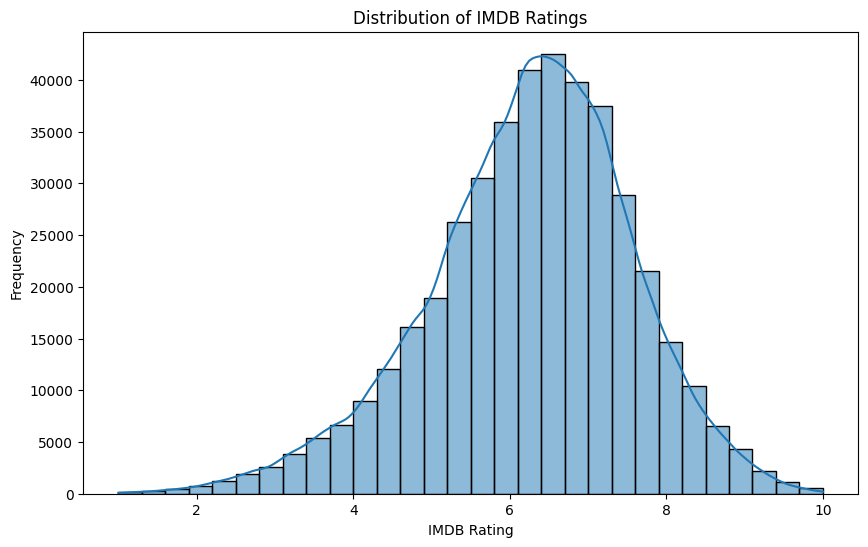

In [13]:
plt.figure(figsize=(10, 6))
sns.histplot(df['imdb_rating'], bins=30, kde=True)
plt.title('Distribution of IMDB Ratings')
plt.xlabel('IMDB Rating')
plt.ylabel('Frequency')
plt.show()

## Input variables
### vote_count & vote_average

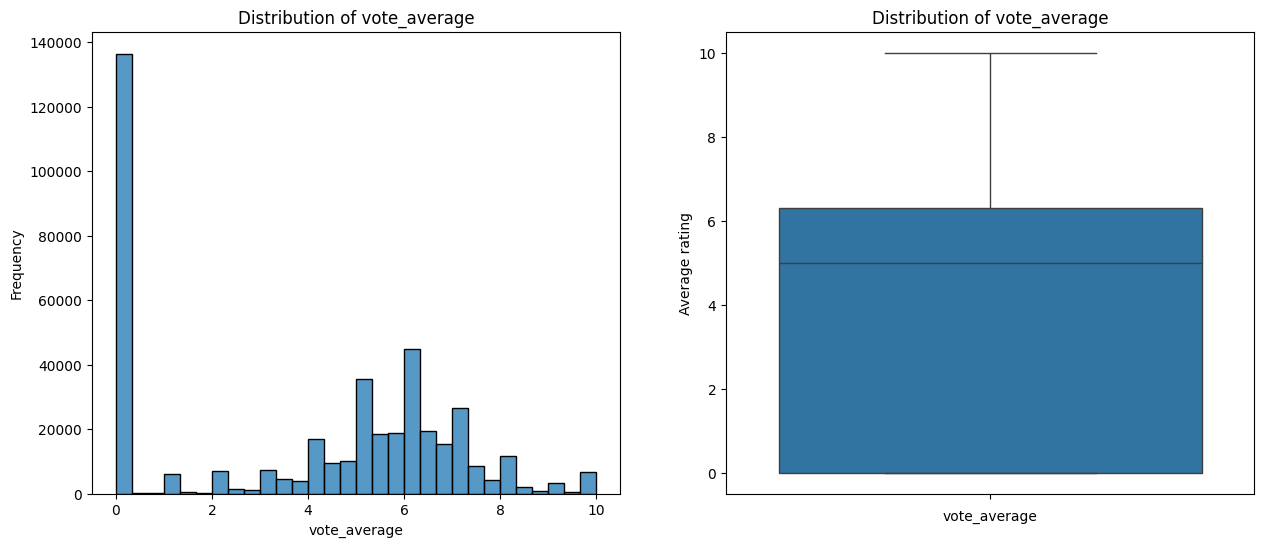

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(15, 6))
sns.histplot(df['vote_average'], bins=30, ax=ax[0])
ax[0].set_title('Distribution of vote_average')
ax[0].set_xlabel('vote_average')
ax[0].set_ylabel('Frequency')
sns.boxplot(df['vote_average'], ax=ax[1])
ax[1].set_title('Distribution of vote_average')
ax[1].set_xlabel('vote_average')
ax[1].set_ylabel('Average rating')
plt.show()

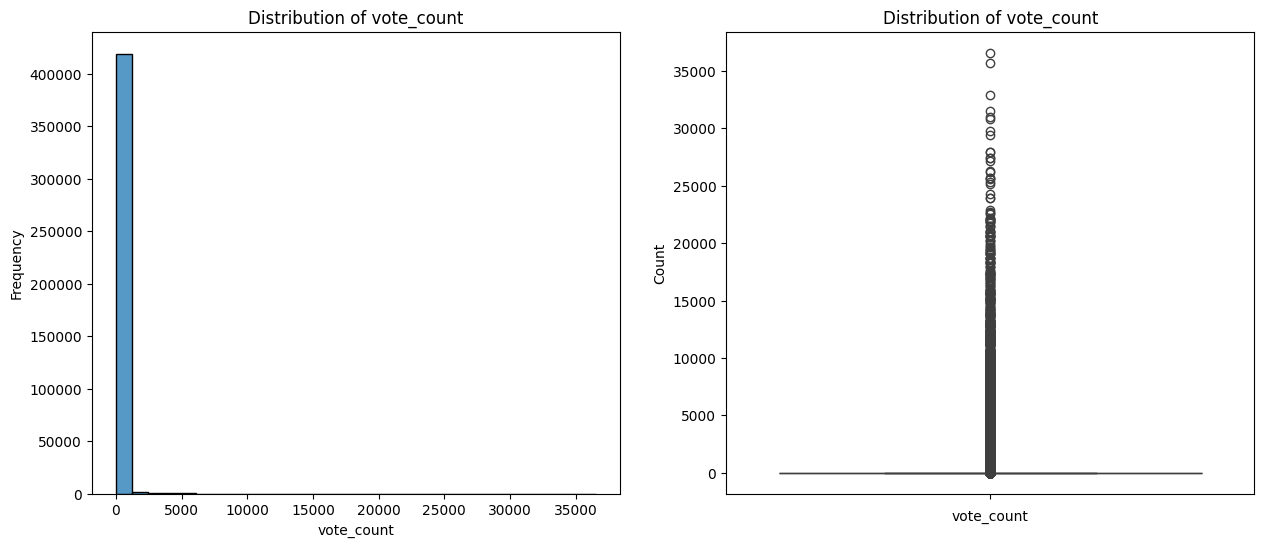

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(15, 6))
sns.histplot(df['vote_count'], bins=30, ax=ax[0])
ax[0].set_title('Distribution of vote_count')
ax[0].set_xlabel('vote_count')
ax[0].set_ylabel('Frequency')
sns.boxplot(df['vote_count'], ax=ax[1])
ax[1].set_title('Distribution of vote_count')
ax[1].set_xlabel('vote_count')
ax[1].set_ylabel('Count')
plt.show()

This is a highly skewed graph. It is not the result of any weird outliers, but the result of having too many movies with a every small number of vote_count and vote_average of zero.\
Let's see their distributions putting together.

Text(0.5, 1.0, 'Scatterplot of vote_average vs vote_count')

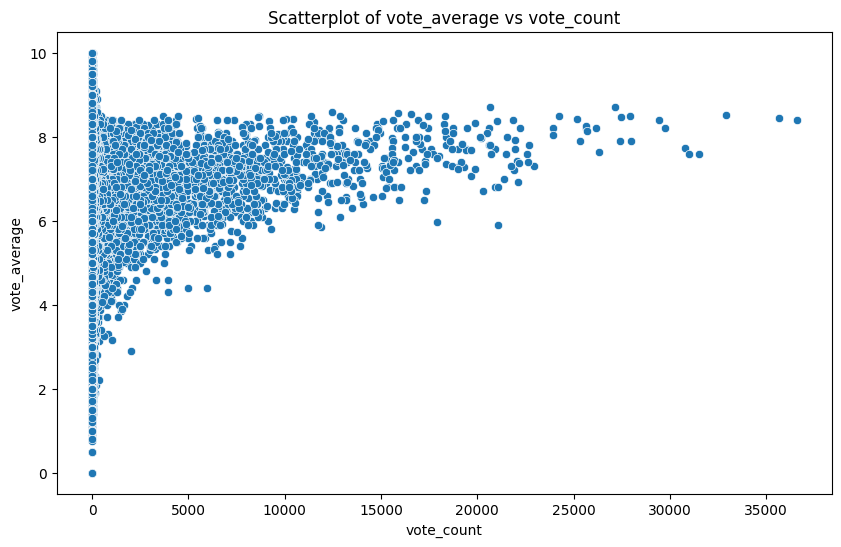

In [16]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='vote_count', y='vote_average', data=df)
plt.title('Scatterplot of vote_average vs vote_count')

Now we will try to check the distribution without movies with zero votes.

In [17]:
vote_df = df[['vote_average', 'vote_count']]
rows_before = vote_df.shape[0]
vote_df = vote_df[vote_df['vote_count'] > 0]
rows_after = vote_df.shape[0]
print(f'Number of movies with zero votes: {rows_before - rows_after}')

Number of movies with zero votes: 136253


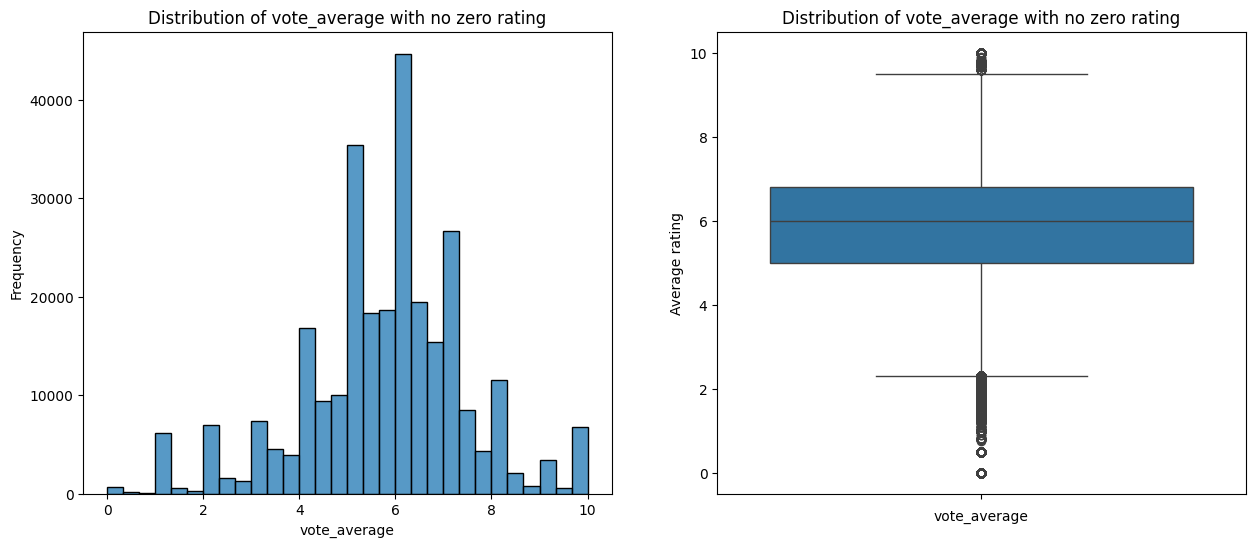

In [19]:
fig, ax = plt.subplots(1, 2, figsize=(15, 6))
sns.histplot(vote_df['vote_average'], bins=30, ax=ax[0])
ax[0].set_title('Distribution of vote_average with no zero rating')
ax[0].set_xlabel('vote_average')
ax[0].set_ylabel('Frequency')
sns.boxplot(vote_df['vote_average'], ax=ax[1])
ax[1].set_title('Distribution of vote_average with no zero rating')
ax[1].set_xlabel('vote_average')
ax[1].set_ylabel('Average rating')
plt.show()

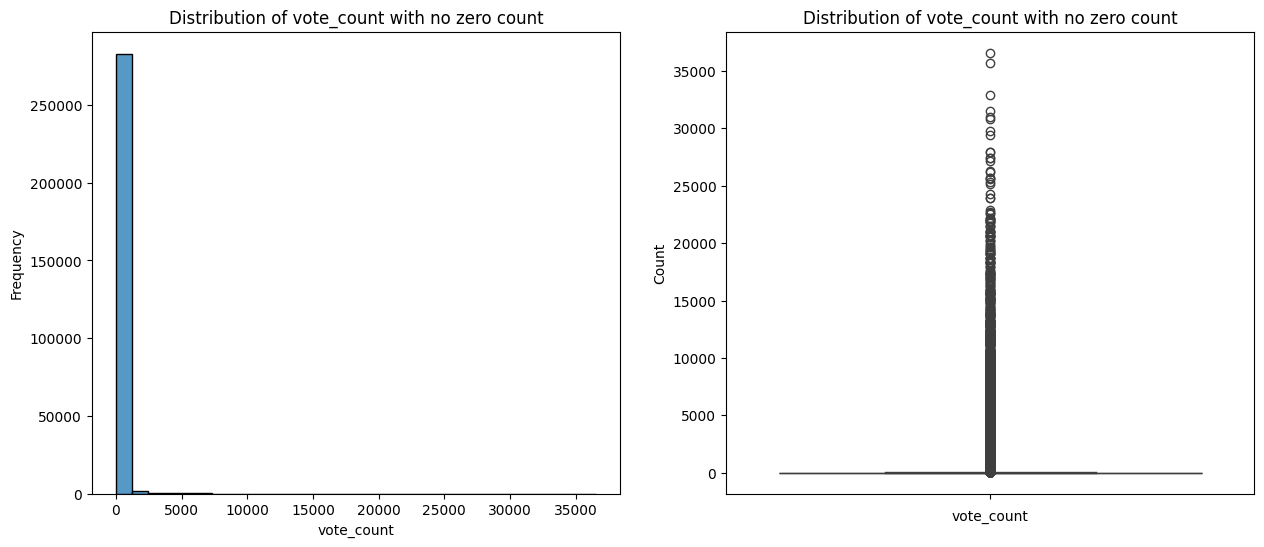

In [20]:
fig, ax = plt.subplots(1, 2, figsize=(15, 6))
sns.histplot(vote_df['vote_count'], bins=30, ax=ax[0])
ax[0].set_title('Distribution of vote_count with no zero count')
ax[0].set_xlabel('vote_count')
ax[0].set_ylabel('Frequency')
sns.boxplot(vote_df['vote_count'], ax=ax[1])
ax[1].set_title('Distribution of vote_count with no zero count')
ax[1].set_xlabel('vote_count')
ax[1].set_ylabel('Count')
plt.show()

The distribution of vote_count is still highly skewed since there is a lot of movies with only a small number of votes.

### Status

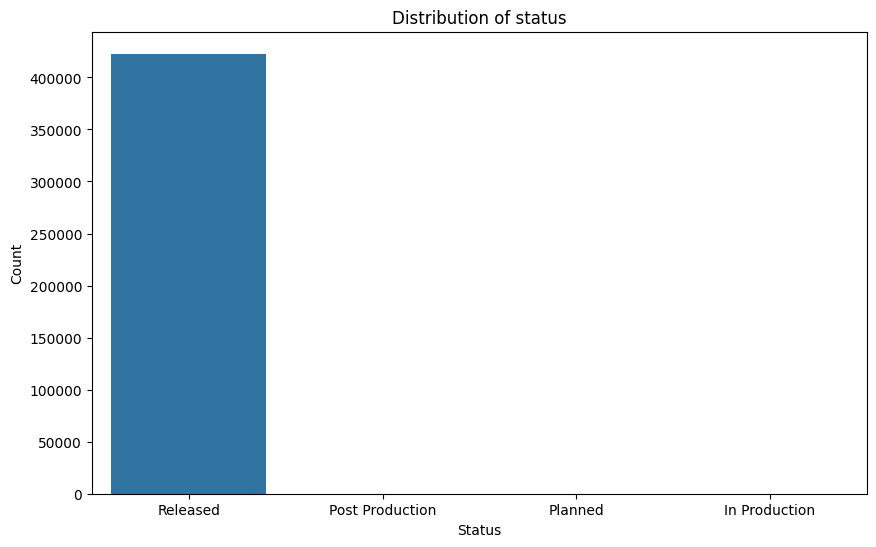

In [21]:
plt.figure(figsize=(10, 6))
sns.countplot(x=df['status'])
plt.title('Distribution of status')
plt.xlabel('Status')
plt.ylabel('Count')
plt.show()

In [22]:
df['status'].value_counts()

status
Released           422755
Post Production        31
In Production          20
Planned                 6
Name: count, dtype: int64

### release_date

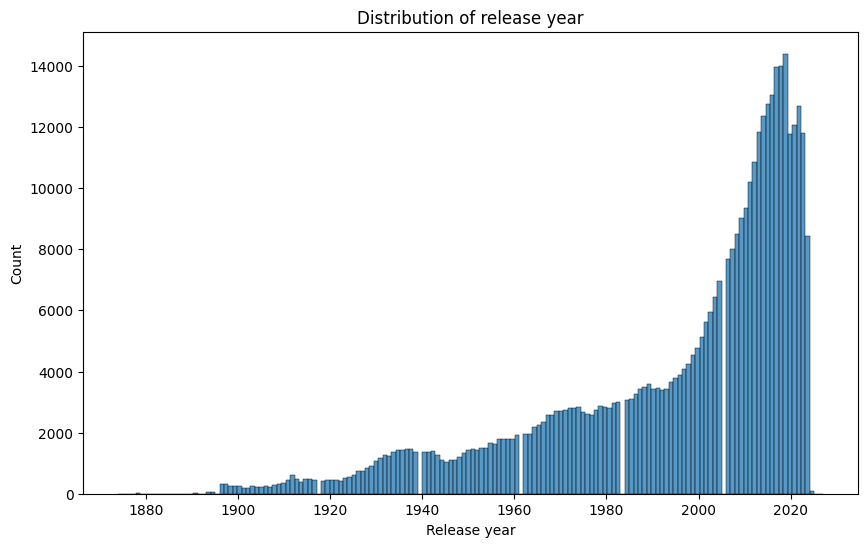

In [23]:
dates = pd.to_datetime(df['release_date'])
plt.figure(figsize=(10, 6))
sns.histplot(dates.dt.year)
plt.title('Distribution of release year')
plt.xlabel('Release year')
plt.ylabel('Count')
plt.show()

### revenue




In [24]:
df['revenue'].value_counts(ascending=False)

revenue
0.0           403667
100000.0          91
1000000.0         80
2000000.0         77
10000.0           67
               ...  
3984000.0          1
18027218.0         1
950.0              1
2355091.0          1
370400.0           1
Name: count, Length: 15367, dtype: int64

Since most of the movies does not have any revenue, it will be another skewed distribution. We will get rid of all the zeros and display the distribution of rest of the data.

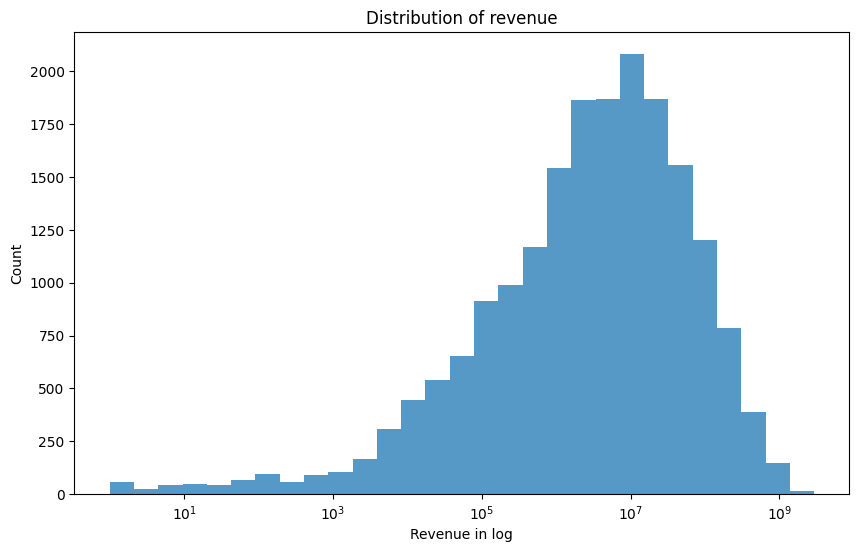

In [25]:
r = df[df['revenue']>0]['revenue']
min_val = r.min()
max_val = r.max()
bins = np.logspace(np.log10(min_val), np.log10(max_val), 30)

plt.figure(figsize=(10, 6))
sns.histplot(r, bins=bins)
plt.title('Distribution of revenue')
plt.xlabel('Revenue in log')
plt.ylabel('Count')
plt.xscale('log')
plt.show()

## Encoding

### Encoding Categorical Features

In [26]:
# Handle orginal_title
df['original_title_match'] = df['original_title'] == df['title']
df.drop(columns=['original_title'], inplace=True)

In [27]:
categorical_vars = df.select_dtypes(include=['object', 'category', 'bool']).columns
print("Categorical variables in the DataFrame:")
print(categorical_vars)

Categorical variables in the DataFrame:
Index(['title', 'status', 'release_date', 'original_language', 'tagline',
       'genres', 'production_companies', 'production_countries',
       'spoken_languages', 'cast', 'director', 'director_of_photography',
       'writers', 'producers', 'music_composer', 'original_title_match'],
      dtype='object')


In [28]:
finite_categories = ['status', 'original_language', 'genres', 'production_companies',
                     'production_countries', 'spoken_languages', 'original_title_match']
for col in finite_categories:
    print(f"\nColumn: {col}")
    print("Unique values:", df[col].unique())


Column: status
Unique values: ['Released' 'Post Production' 'Planned' 'In Production']

Column: original_language
Unique values: ['fi' 'en' 'de' 'he' 'es' 'zh' 'ja' 'da' 'fr' 'ko' 'pl' 'sv' 'it' 'bs'
 'hi' 'ru' 'no' 'pt' 'nl' 'el' 'cs' 'bn' 'cn' 'tn' 'sr' 'mn' 'et' 'is'
 'ca' 'ro' 'hu' 'se' 'ps' 'th' 'xx' 'tr' 'sh' 'fa' 'ht' 'bg' 'zu' 'ar'
 'mr' 'ku' 'bo' 'ta' 'tl' 'kk' 'hr' 'id' 'am' 'lt' 'iu' 'pa' 'te' 'sl'
 'vi' 'ml' 'mk' 'sk' 'af' 'ur' 'km' 'nb' 'ms' 'hy' 'uk' 'ka' 'la' 'kn'
 'dz' 'ga' 'eu' 'bm' 'sq' 'gl' 'mo' 'si' 'rw' 'ky' 'eo' 'xh' 'az' 'jv'
 'tg' 'ff' 'lv' 'oc' 'wo' 'ik' 'uz' 'lo' 'ks' 'sm' 'gd' 'cy' 'ln' 'sn'
 'yi' 'tk' 'ab' 'mt' 'sw' 'kl' 'ne' 'fo' 'so' 've' 'lb' 'sa' 'co' 'yo'
 'fy' 'gu' 'sc' 'ig' 'ay' 'mg' 'gn' 'qu' 'cr' 'cv' 'mh' 'mi' 'my' 'to'
 'dv' 'tw' 'or' 'st' 'li' 'as' 'ha' 'ug' 'ak' 'nn' 'be' 'ti' 'ny' 'ty'
 'ss' 'om' 'tt' 'ce' 'rm' 'os' 'nv' 'gv' 'sd' 'lg' 'ba' 'su' 'kg' 'kw'
 'nd' 'sg']

Column: genres
Unique values: ['Comedy, Drama, Romance, Crime' 'Comedy, Dram

In [29]:
# One-hot encode
one_hot_encoder = OneHotEncoder(sparse_output=False, drop='first')
status_encoded = one_hot_encoder.fit_transform(df[['status', 'original_title_match']])

status_encoded_df = pd.DataFrame(status_encoded,
                                 columns=one_hot_encoder.get_feature_names_out(['status', 'original_title_match']),
                                 index=df.index)
df = pd.concat([df, status_encoded_df], axis=1)
df.drop(columns=['status', 'original_title_match'], inplace=True)

# Target encode
target_encode_cols = ['original_language', 'production_companies', 'production_countries', 'spoken_languages', 'genres']
target_col = 'imdb_rating'
df[target_encode_cols] = df[target_encode_cols].fillna('Missing')

for col in target_encode_cols:
    target_mean = df.groupby(col)[target_col].mean()
    df[f"{col}_target_encoded"] = df[col].map(target_mean)

df.drop(columns=target_encode_cols, inplace=True)

print(df.head())

                              title  vote_average  vote_count release_date  \
0                             Ariel           7.1       335.0   1988-10-21   
1               Shadows in Paradise           7.3       369.0   1986-10-17   
2                        Four Rooms           5.8      2628.0   1995-12-09   
3                    Judgment Night           6.5       331.0   1993-10-15   
4  Life in Loops (A Megacities RMX)           7.5        27.0   2006-01-01   

      revenue  runtime      budget  popularity  \
0         0.0     73.0         0.0      11.915   
1         0.0     74.0         0.0      16.287   
2   4257354.0     98.0   4000000.0      21.312   
3  12136938.0    109.0  21000000.0       8.924   
4         0.0     80.0     42000.0       3.203   

                                             tagline  \
0                                                NaN   
1                                                NaN   
2  Twelve outrageous guests. Four scandalous requ...   
3     

### Dimension Reduction:

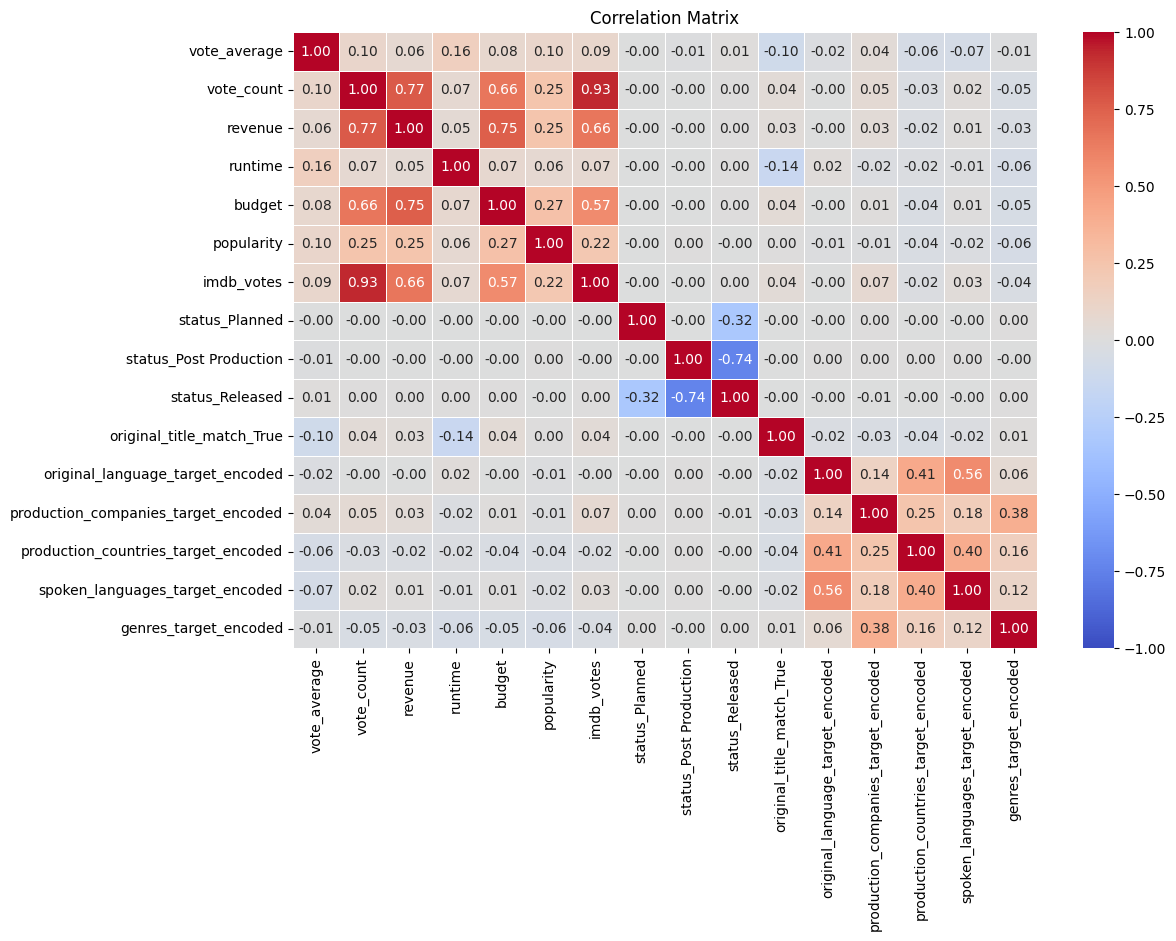

Dropped columns: {'imdb_votes'}
                              title  vote_average  vote_count release_date  \
0                             Ariel           7.1       335.0   1988-10-21   
1               Shadows in Paradise           7.3       369.0   1986-10-17   
2                        Four Rooms           5.8      2628.0   1995-12-09   
3                    Judgment Night           6.5       331.0   1993-10-15   
4  Life in Loops (A Megacities RMX)           7.5        27.0   2006-01-01   

      revenue  runtime      budget  popularity  \
0         0.0     73.0         0.0      11.915   
1         0.0     74.0         0.0      16.287   
2   4257354.0     98.0   4000000.0      21.312   
3  12136938.0    109.0  21000000.0       8.924   
4         0.0     80.0     42000.0       3.203   

                                             tagline  \
0                                                NaN   
1                                                NaN   
2  Twelve outrageous guests. F

In [30]:
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns
numerical_cols = numerical_cols.drop(['imdb_rating'])
df_numerical = df[numerical_cols]
correlation_matrix = df_numerical.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5, vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show()


cols_to_drop = set()

for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.8:
            colname = correlation_matrix.columns[i]
            cols_to_drop.add(colname)

df.drop(columns=cols_to_drop, inplace=True)

print(f"Dropped columns: {cols_to_drop}")
print(df.head())


### Handling release_date

In [31]:
df['release_date'] = pd.to_datetime(df['release_date'])
df['decade'] = (df['release_date'].dt.year // 10) * 10
decades = df['decade'].values.reshape(-1, 1)

encoder = OrdinalEncoder()
df['release_date_decade_encoded'] = encoder.fit_transform(decades)
df.drop(columns=['release_date', 'decade'], inplace=True)

### Text Vectorization

In [32]:
vectorize_cols = ['title', 'tagline', 'cast', 'director',
                  'director_of_photography', 'writers',
                  'producers', 'music_composer']

# vectorize_cols = ['title']

vectorizer = TfidfVectorizer(stop_words='english', max_features=100)

for col in tqdm(vectorize_cols):
    df[col] = df[col].fillna('')
    df[col] = df[col].apply(lambda x: ' '.join([name.strip().replace(' ', '_') for name in x.split(',')]))


    tfidf_matrix = vectorizer.fit_transform(df[col])

    tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out(), index=df.index)

    df = pd.concat([df, tfidf_df], axis=1)

print(df.head())

100%|██████████| 8/8 [00:22<00:00,  2.87s/it]

                              title  vote_average  vote_count     revenue  \
0                             Ariel           7.1       335.0         0.0   
1               Shadows_in_Paradise           7.3       369.0         0.0   
2                        Four_Rooms           5.8      2628.0   4257354.0   
3                    Judgment_Night           6.5       331.0  12136938.0   
4  Life_in_Loops_(A_Megacities_RMX)           7.5        27.0         0.0   

   runtime      budget  popularity  \
0     73.0         0.0      11.915   
1     74.0         0.0      16.287   
2     98.0   4000000.0      21.312   
3    109.0  21000000.0       8.924   
4     80.0     42000.0       3.203   

                                             tagline  \
0                                                      
1                                                      
2  Twelve_outrageous_guests._Four_scandalous_requ...   
3     Don't_move._Don't_whisper._Don't_even_breathe.   
4                           

In [33]:
df = df.drop(columns=vectorize_cols)
print(df.shape)

(422812, 817)


## Sampling & Normalization

In [34]:
normalize_col = ['vote_average', 'vote_count', 'revenue', 'budget', 'popularity', 'runtime',
                 'release_date_decade_encoded', 'original_language_target_encoded', 'production_companies_target_encoded',
                 'production_countries_target_encoded', 'spoken_languages_target_encoded', 'genres_target_encoded']

### Random split

In [35]:
X_train, X_test, y_train, y_test= train_test_split(df.drop(columns=['imdb_rating']), df['imdb_rating'], test_size=0.1, random_state=42)
scaler = StandardScaler()
X_train[normalize_col] = scaler.fit_transform(X_train[normalize_col])
X_test[normalize_col] = scaler.transform(X_test[normalize_col])
print(f'Shape of the training set: {X_train.shape}')
print(f'Shape of the test set: {X_test.shape}')

Shape of the training set: (380530, 816)
Shape of the test set: (42282, 816)


### Stratified split

In [36]:
kbd = KBinsDiscretizer(n_bins=30, encode='ordinal', strategy='quantile')
y_bin = kbd.fit_transform(df[['imdb_rating']])
X_train_str, X_temp_str, y_train_str, y_temp_str = train_test_split(df.drop(columns=['imdb_rating']), df['imdb_rating'], test_size=0.2, random_state=42, stratify=y_bin)
y_temp_str = pd.DataFrame(y_temp_str, columns=['imdb_rating'])
y_test_bin = kbd.transform(y_temp_str)
X_val_str, X_test_str, y_val_str, y_test_str = train_test_split(X_temp_str, y_temp_str, test_size=0.5, random_state=42, stratify=y_test_bin)
scaler_str = StandardScaler()
X_train_str[normalize_col] = scaler_str.fit_transform(X_train_str[normalize_col])
X_val_str[normalize_col] = scaler_str.transform(X_val_str[normalize_col])
X_test_str[normalize_col] = scaler_str.transform(X_test_str[normalize_col])
print(f'Shape of the training set: {X_train_str.shape}')
print(f'Shape of the validation set: {X_val_str.shape}')
print(f'Shape of the test set: {X_test_str.shape}')

Shape of the training set: (338249, 816)
Shape of the validation set: (42281, 816)
Shape of the test set: (42282, 816)


## Model

### KNN

In [ ]:
param_grid = {'n_neighbors': [5, 10, 20, 50, 100],
              'leaf_sizes': [30, 50, 100]}
best_val_score = 0
best_params = None
for n_neighbors in param_grid['n_neighbors']:
    for leaf_size in param_grid['leaf_sizes']:
        knn = KNeighborsRegressor(n_neighbors=n_neighbors, leaf_size=leaf_size)
        knn.fit(X_train_str, y_train_str)
        val_score = knn.score(X_val_str, y_val_str)
        if val_score > best_val_score:
            best_val_score = val_score
            best_params = {'n_neighbors': n_neighbors, 'leaf_size': leaf_size}
print(f'Best validation score: {best_val_score}')
print(f'Best parameters: {best_params}')

In [ ]:
best_knn = KNeighborsRegressor(n_neighbors=best_params['n_neighbors'], leaf_size=best_params['leaf_size'])
best_knn.fit(X_train_str, y_train_str)
test_score = best_knn.score(X_test_str, y_test_str)
print(f'Test score for best model: {test_score}')

Test score for best model: 0.5786474762650851


In [ ]:
param_grid_str = {'n_neighbors': [5, 10, 20, 50, 100],
                    'leaf_sizes': [30, 50, 100]}
best_val_score_str = 0
best_params_str = None
for n_neighbors in param_grid_str['n_neighbors']:
    for leaf_size in param_grid_str['leaf_sizes']:
        knn = KNeighborsRegressor(n_neighbors=n_neighbors, leaf_size=leaf_size)
        knn.fit(X_train_str, y_train_str)
        val_score = knn.score(X_val_str, y_val_str)
        if val_score > best_val_score_str:
            best_val_score_str = val_score
            best_params_str = {'n_neighbors': n_neighbors, 'leaf_size': leaf_size}
print(f'Best stratified validation score: {best_val_score_str}')
print(f'Best stratified parameters: {best_params_str}')

Best stratified validation score: 0.5859395407481365
Best stratified parameters: {'n_neighbors': 50, 'leaf_size': 30}


In [ ]:
best_knn_str = KNeighborsRegressor(n_neighbors=best_params_str['n_neighbors'], leaf_size=best_params_str['leaf_size'])
best_knn_str.fit(X_train_str, y_train_str)
test_score_str = best_knn_str.score(X_test_str, y_test_str)
print(f'Test score for best stratified model: {test_score_str}')

Test score for best stratified model: 0.5786474762650851


### SVM

In [ ]:
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
param_grid = {
    'C': [0.1, 1, 10, 100],
    'epsilon': [0.1, 0.5, 1, 2],
    'kernel': ['linear', 'rbf']
}
best_val_score = float('-inf')
best_params = None

for C in param_grid['C']:
  for epsilon in param_grid['epsilon']:
    for kernel in param_grid['kernel']:
      svr = SVR(C=C, epsilon=epsilon, kernel=kernel)
      svr.fit(X_train_str, y_train_str)
      val_score = svr.score(X_val_str, y_val_str)

      if val_score > best_val_score:
        best_val_score = val_score
        best_params = {'C': C, 'epsilon': epsilon, 'kernel': kernel}
print(f'Best validation score: {best_val_score}')
print(f'Best parameters: {best_params}')

In [ ]:
best_svr = SVR(C=best_params['C'], epsilon=best_params['epsilon'], kernel=best_params['kernel'])
best_svr.fit(X_train_str, y_train_str)
test_score = best_svr.score(X_test_str, y_test_str)
print(f'Test score for best model: {test_score}')

### Tree Based (XGBoost)

In [ ]:
import xgboost as xgb
xgb_param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [50, 100, 200]
}
best_xgb_val_score = float('-inf')
best_xgb_params = None

for max_depth in xgb_param_grid['max_depth']:
    for learning_rate in xgb_param_grid['learning_rate']:
        for n_estimators in xgb_param_grid['n_estimators']:
            xgboost_model = xgb.XGBRegressor(max_depth=max_depth, learning_rate=learning_rate, n_estimators=n_estimators)
            xgboost_model.fit(X_train_str, y_train_str)
            val_score = xgboost_model.score(X_val_str, y_val_str)

            if val_score > best_xgb_val_score:
                best_xgb_val_score = val_score
                best_xgb_params = {
                    'max_depth': max_depth,
                    'learning_rate': learning_rate,
                    'n_estimators': n_estimators
                }

print(f'Best XGBoost validation score: {best_xgb_val_score}')
print(f'Best XGBoost parameters: {best_xgb_params}')



In [ ]:
best_xgboost_model = xgb.XGBRegressor(**best_xgb_params)
best_xgboost_model.fit(X_train_str, y_train_str)
xgb_test_score = best_xgboost_model.score(X_test_str, y_test_str)
print(f'Test score for best XGBoost model: {xgb_test_score}')